In [1]:

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from lib.data_normalizer import draw_image_with_boxes

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

IMAGE_SHAPE = (256,256)


2022-11-02 21:21:19.002318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 21:21:20.824407: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2022-11-02 21:21:20.824475: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2022-11-02 21:21:20.830645: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2022-11-02 21:21:22.258315: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


## Modelo de identificación de placas

In [2]:
model = models.Sequential([

#   Convolution layers
    layers.Conv2D(64, (8, 8), activation='relu', padding="same", input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (5, 5), activation='relu', padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding="same"),

#   Normal layers
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2), # Evita la conexión total entre capaz para evitar overfitting
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4,activation='sigmoid'),   # 5 neuronas de salida, desempeño + fronteras
])
model.summary()

model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# Comentarios

# 1. muestreo %validación %entrenamiento
# 2. Cargar imágenes
# 3. Modelo
# 4. Entrenamiento
# 5. Validación
# 6. gráficas entrenamiento validación
# 7. Función de aplicación

2022-11-02 21:21:25.079432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 21:21:25.080089: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon R9 200 Series)
2022-11-02 21:21:25.759905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-02 21:21:25.759940: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2022-11-02 21:21:25.759962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      12352     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 65536)             0

## Carga de Datos

In [3]:

# Load csv
plates_data = pd.read_csv("./normalized_data/unique_plates.csv")

# Take a sample of the data
number_of_samples = 800;
plates_data_sample = plates_data.sample(number_of_samples)

# Create arrays with inputs and outputs
plates_data_in = np.ndarray(shape=(number_of_samples, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3), dtype=np.uint8)
plates_data_out = np.array([plates_data_sample['xmin'],
                            plates_data_sample['ymin'],
                            plates_data_sample['xmax'],
                            plates_data_sample['ymax']]).T


# Load images from paths in csv

for i, path in enumerate(plates_data_sample['img_path']):
    raw_image = cv2.imread(path, cv2.IMREAD_COLOR)
    plates_data_in[i,:,:,:] = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)  # Reorganize channels to RGB instead of BGR

# Normalize inputs
for i in range(len(plates_data_out)):
    # plates_data_out[i][0] = plates_data_out[i][0] / 100           # tag
    plates_data_out[i][0] = plates_data_out[i][0] / IMAGE_SHAPE[0]  # xmin
    plates_data_out[i][1] = plates_data_out[i][1] / IMAGE_SHAPE[1]  # ymin
    plates_data_out[i][2] = plates_data_out[i][2] / IMAGE_SHAPE[0]  # xmax
    plates_data_out[i][3] = plates_data_out[i][3] / IMAGE_SHAPE[1]  # ymax


# print first column of plates_data_sample
#plt.imshow(plates_data_in[i])
#plt.show()

## Test de datos

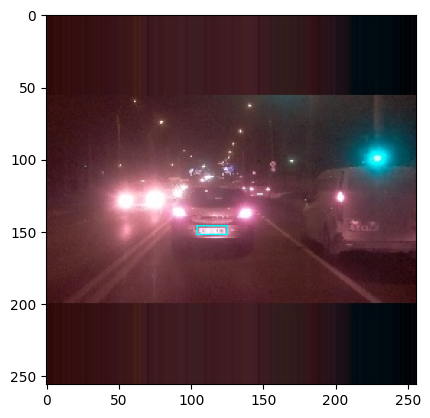

In [5]:


i = 200
# Scale predicted data
predicted_data = [[0.0,0.0,0.0,0.0,0.0]]
predicted_data[0][1] = plates_data_out[i][0] * IMAGE_SHAPE[0]  # xmin
predicted_data[0][2] = plates_data_out[i][1] * IMAGE_SHAPE[1]  # ymin
predicted_data[0][3] = plates_data_out[i][2] * IMAGE_SHAPE[0]  # xmax
predicted_data[0][4] = plates_data_out[i][3] * IMAGE_SHAPE[1]  # ymax


draw_image_with_boxes(plates_data_in[i], predicted_data, border = 1)


## Entrenamiento

In [6]:
history = model.fit(plates_data_in, plates_data_out,
                    validation_split=0.2,
                    epochs=10,
                    batch_size = 50).history

model.save('models/model.h5')

2022-11-02 21:21:50.310336: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 125829120 exceeds 10% of free system memory.
2022-11-02 21:21:50.729332: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 125829120 exceeds 10% of free system memory.


Epoch 1/10


2022-11-02 21:21:51.327032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-02 21:21:51.391471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-02 21:21:51.391544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 9472 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


13/13 [==============================] - ETA: 0s - loss: 33728.4180 - accuracy: 0.3141

2022-11-02 21:22:05.106387: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31457280 exceeds 10% of free system memory.
2022-11-02 21:22:05.140387: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31457280 exceeds 10% of free system memory.
2022-11-02 21:22:05.242007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-02 21:22:05.265480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-02 21:22:05.265516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 9472 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


13/13 [==============================] - 15s 894ms/step - loss: 33728.4180 - accuracy: 0.3141 - val_loss: 155730.0000 - val_accuracy: 0.5000
Epoch 2/10
13/13 [==============================] - 11s 879ms/step - loss: 6204806.5000 - accuracy: 0.2938 - val_loss: 14149904.0000 - val_accuracy: 0.5000
Epoch 3/10
13/13 [==============================] - 11s 882ms/step - loss: 248199584.0000 - accuracy: 0.3281 - val_loss: 407660832.0000 - val_accuracy: 0.5000
Epoch 4/10
13/13 [==============================] - 11s 884ms/step - loss: 4955725312.0000 - accuracy: 0.3000 - val_loss: 6208245248.0000 - val_accuracy: 0.5000
Epoch 5/10
13/13 [==============================] - 11s 880ms/step - loss: 52516048896.0000 - accuracy: 0.2641 - val_loss: 50148126720.0000 - val_accuracy: 0.5000
Epoch 6/10
13/13 [==============================] - 11s 881ms/step - loss: 364281331712.0000 - accuracy: 0.3016 - val_loss: 256589742080.0000 - val_accuracy: 0.5000
Epoch 7/10
13/13 [==============================] - 11s

## Usar modelo

(1, 256, 256, 3)
1/1 [==============================] - 0s 50ms/step
Salida: [[256. 256. 256. 256.]]


2022-11-02 20:09:21.044985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


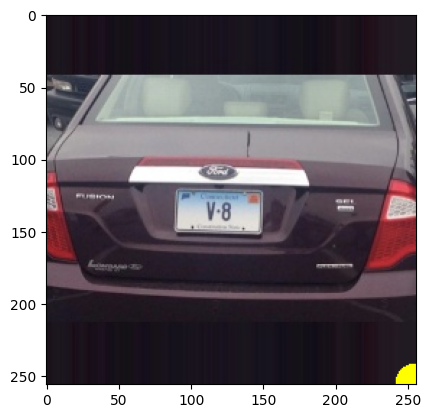

In [11]:
model = models.load_model("./models/model.h5")

test_image = np.ndarray(shape=(1, 256, 256, 3), dtype=np.uint8)
test_image[0] = cv2.cvtColor(cv2.imread("./normalized_data/plates_images/13.jpg", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
print(test_image.shape)
predicted_data = model.predict(test_image)

# Scale predicted data
predicted_data[0][0] = predicted_data[0][0] * IMAGE_SHAPE[0]  # xmin
predicted_data[0][1] = predicted_data[0][1] * IMAGE_SHAPE[1]  # ymin
predicted_data[0][2] = predicted_data[0][2] * IMAGE_SHAPE[0]  # xmax
predicted_data[0][3] = predicted_data[0][3] * IMAGE_SHAPE[1]  # ymax

printable_data = [[0, predicted_data[0][0], predicted_data[0][1], predicted_data[0][2], predicted_data[0][3]]]

# predicted_data[0][1] = 10  # xmin
# predicted_data[0][2] = 10  # ymin
# predicted_data[0][3] = 100  # xmax
# predicted_data[0][4] = 100  # ymax

print("Salida: " + str(predicted_data))
draw_image_with_boxes(test_image[0], printable_data, border = 1)

In [15]:
print(model.input_shape)

(None, 256, 256, 3)
